## Imports

In [1]:
import load_data
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import os
import preprocess
from tensorflow import keras

## Constants 

In [2]:
# SAVE_HISTORY = True: Es speichert die Plots im Ordner "test_results"
SAVE_HISTORY = True

# MODEL_SAVE = True: Es speichert das Modell im Ordner "arch" mit den Name von "MODEL_NAME"
MODEL_SAVE = False
MODEL_NAME = "Default" # Am besten mit der Aenderung im Modell bennen 
MODEL_DIR_NAME = pathlib.Path(os.getcwd()).joinpath('arch')
TEST_RESULT_DIR_NAME = pathlib.Path(os.getcwd()).joinpath('test_results')

EPOCHS = 5
BATCH_SIZE = 32

IMAGE_WIDTH = preprocess.image_width
IMAGE_HEIGHT = preprocess.image_height

## Load Data

In [3]:
load_data.print_samples()
x_train_img_paths, y_train_labels = load_data.get_train_data()
x_test_img_paths, y_test_labels = load_data.get_test_data()
x_val_img_paths, y_val_labels = load_data.get_validation_data()

Total train samples: 10209
Total validation samples: 567
Total test samples: 568
Maximum length:  93
Vocab size:  79


In [ ]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

## Create Dataset

In [4]:
# Has to be here because load data functions need to be called before
import tokenizer
import custom_image_generator as cgi

# takes eternity
#x_train, y_train = tokenizer.prepare_data(x_train_img_paths, y_train_labels) 
#x_test, y_test = tokenizer.prepare_data(x_test_img_paths, y_test_labels)
train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels)
test_ds = tokenizer.prepare_dataset(x_test_img_paths, y_test_labels)

## Show Examples

In [ ]:
for data in test_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 4))[1]

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

# Augmentation

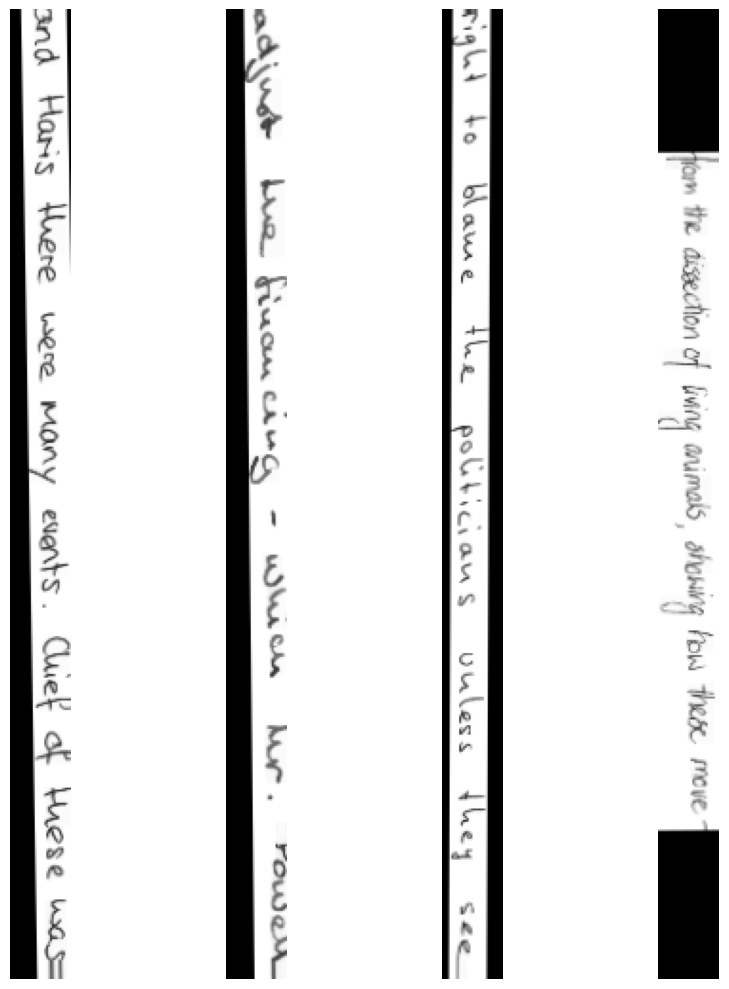

In [20]:
train_generator = cgi.CustomImageGenerator(x_train_img_paths, y_train_labels, BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT)

example_batch = train_generator[0]
augmented_images = example_batch[0]['image']

num_to_plot = 4
fig, axes = plt.subplots(1, num_to_plot, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.squeeze(augmented_images[i]), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomBrightness(0.5,value_range=(0, 1), seed=42)
    ]
)

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 4, 1)
plt.imshow(images[0].numpy(), cmap='gray', vmin=0, vmax=1)
plt.title("Original Image")

# Apply data augmentation to the image
augmented_images = data_augmentation(images, training=True)

# Display the augmented images
for i in range(3):
    plt.subplot(1, 4, i + 2)
    plt.imshow(augmented_images[i].numpy(), cmap='gray', vmin=0, vmax=1)
    plt.title(f"Augmented Image {i+1}")
    
plt.show()

## CTC Layer

In [ ]:
import keras
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

## Keras Model

In [ ]:
def build_model9v3():
    input_img = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))
    
    x = keras.layers.Conv2D(48, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = keras.layers.Conv2D(96, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = keras.layers.Conv2D(48, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv3")(x)
    x = keras.layers.Conv2D(96, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv4")(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = keras.layers.Dropout(0.2)(x)
    
    new_shape = ((IMAGE_WIDTH // 4), (IMAGE_HEIGHT // 4) * 96)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(128, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)
                                
    x = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

    x = keras.layers.Dense(len(tokenizer.char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt)
    return model

# Callback

In [ ]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True,patience=5)

In [ ]:
# Train the Model

In [ ]:
def train_model(model):
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)

    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,callbacks=monitor)
    return prediction_model, history

In [ ]:
# Get the model.
model = build_model9v3()
model.summary()

In [ ]:
prediction_model, history = train_model(model)

## Training with augmented data

In [ ]:
train_generator = cgi.CustomImageGenerator(x_train_img_paths, y_train_labels, BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT)
history = model.fit(train_generator, steps_per_epoch=len(train_generator), validation_data=val_ds, epochs=EPOCHS, callbacks=monitor)

## Helper functions


In [ ]:
def plot_history_simple(history):
    """
    Plottet die Historie des Trainings eines Models

    :param history: Das trainierte Modell
    :return: void
    """
    metrics = history.history
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.show()

In [ ]:
def plot_history(history, name, dir_path):
    """
    Plottet die Historie des Trainings eines Models und speichert die in einem Verzeichnis ab 

    :param history: Das trainierte Modell
    :param name: Name, wie das Modell gespeicht werden soll
    :param name: Verzeichniss, wo der Plot gespeichert weren soll
    :return: void
    """
    metrics = history.history
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.title('Name: '+name)
    path = os.path.join(dir_path, name + '_history.png')
    plt.savefig(path)
    plt.show()

In [ ]:
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
def plot_evaluation(name, dir_path, save):
    if save:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)

    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 4))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
            

    plt.show()


In [ ]:
#test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)

## Model Testing

In [ ]:
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL".format(
    name=MODEL_NAME, epoch=EPOCHS, height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1]), val_loss=round(metrics['val_loss'][-1]))

if not files_with_model_name:
    if SAVE_HISTORY:
        if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
        plot_history(history, NAME, TEST_RESULT_DIR_NAME)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    plot_history_simple(history)
    plot_evaluation(NAME, TEST_RESULT_DIR_NAME, False)


# Save the Model

In [ ]:
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model.save(os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME)))
    #model.save_weights(os.path.join(MODEL_DIR_NAME, "weights.keras"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(MODEL_DIR_NAME, "model"),'w') as f:
        f.write(json_string)